In [42]:
from pycaret.classification import *
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

import sys
sys.path.insert(1, '../utils')
from run_models.train_predict import train_model, calification_model



In [2]:
experiment_name = 'experiment_3'

## Lectura de Datos

In [3]:
data  = pd.read_csv(r"..\data\{}\pmod_base_model.csv".format(experiment_name))
data.head()

,nit_enmascarado,num_oblig_enmascarado,num_oblig_orig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,marca_pago,avg_sld_cap_final_1,avg_sld_cap_final_stddev_ult3,avg_sld_cap_final_stddev_ult6,avg_nueva_altura_mora_1,avg_nueva_altura_mora_stddev_ult3,min_vlr_obligacion_stddev_ult3,avg_vlr_vencido_1,valor_cuota_mes_1,valor_cuota_mes_stddev_ult3,valor_cuota_mes_stddev_ult6,pago_total_1,pago_total_avg_ult3,porc_pago_1,porc_pago_avg_ult3,total_ing_1,total_ing_avg_ult3,total_ing_stddev_ult3,tot_activos_1,tot_activos_stddev_ult3,tot_activos_stddev_ult6,egresos_mes_1,egresos_mes_stddev_ult3,tot_patrimonio_stddev_ult3,tot_patrimonio_stddev_ult6,prob_propension_1,prob_propension_stddev_ult3,prob_propension_stddev_ult6,prob_propension_max_ult6,prob_alrt_temprana_1,prob_alrt_temprana_stddev_ult3,prob_alrt_temprana_stddev_ult6,prob_auto_cura_1,prob_auto_cura_stddev_ult3,prob_auto_cura_stddev_ult6
0,188431,915475,172650,202401,NaN,PAGO_MENOS,1.115650e+06,5.653806e+04,1.064355e+05,43.161290,18.053716,1.159548e+05,536621.838710,590444.0,148916.089167,154796.176843,98928.0,5.814197e+05,17.0,210.333333,1912467.0,1912467.0,0.0,1039000.0,0.0,0.000000e+00,4500000.0,1.885618e+06,0.0,0.000000e+00,0.613275,0.100086,0.084638,0.850847,0.526956,0.178273,0.177695,0.231158,0.251565,0.229240
1,128408,238252,842090,202310,1.0,PAGO_MENOS,2.280231e+07,5.359791e+05,1.086032e+06,3.233333,0.408891,5.913760e+05,602698.333333,1176848.0,4316.415514,3210.060003,4741413.0,4.325278e+06,403.0,368.666667,11910458.0,11910458.0,0.0,166836000.0,0.0,8.341800e+07,150000.0,0.000000e+00,0.0,7.415800e+07,0.936188,0.005979,0.005512,0.948035,0.704701,0.025402,0.068428,0.385024,0.205688,0.198895
2,85913,154147,926195,202311,1.0,NO_PAGO,2.058486e+06,0.000000e+00,0.000000e+00,32.483871,60.453889,5.273149e+04,256551.516129,176689.0,306671.565942,225688.130029,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.240089,0.094142,0.084231,0.263595,0.679345,0.001512,0.015487,0.174194,0.019490,0.019910
3,156666,665292,414641,202310,1.0,IGUAL,4.579475e+06,1.871246e+06,1.730020e+06,0.000000,0.000000,1.340195e+06,0.000000,258843.0,95470.443811,77909.136291,260543.0,1.189267e+05,101.0,67.000000,8156610.0,8156610.0,0.0,137210000.0,0.0,6.860500e+07,300000.0,0.000000e+00,0.0,6.860500e+07,0.842558,0.010454,0.014062,0.861813,0.088858,0.018362,0.074426,0.783444,0.019748,0.018597
4,282457,594785,485557,202312,1.0,NO_PAGO,2.448075e+06,4.988874e+03,6.385573e+04,15.066667,7.102495,2.946878e+04,88885.400000,88595.0,0.000000,333.227983,0.0,8.859500e+04,0.0,100.000000,1500000.0,1500000.0,0.0,70214000.0,0.0,2.616721e+07,1200000.0,0.000000e+00,0.0,2.616721e+07,0.833070,0.021824,0.038918,0.886956,0.473799,0.110509,0.184936,0.339935,0.089589,0.081181


In [4]:
print("Cantidad de valores:", data.shape)
print("Cantidad de datos con valores infinitos: ", (data.isin([np.inf, -np.inf]).sum()).sum())
print("Cantidad de datos con valores nulos: ", (data.isna().sum()).sum())
print("Cantidad de datos con valores negativos: ", ((data.drop(columns=["marca_pago"]) < 0).sum()).sum())

Cantidad de valores: (680800, 40)
Cantidad de datos con valores infinitos:  0
Cantidad de datos con valores nulos:  113728
Cantidad de datos con valores negativos:  26707


In [5]:
data["marca_pago"] = data["marca_pago"].fillna("NA")

In [6]:
data.shape

(680800, 40)

In [7]:
data_model = data[data["fecha_var_rpta_alt"] < 202401]
data_oot = data[data["fecha_var_rpta_alt"] == 202401]

In [8]:
print("Cantidad de valores:", data_model.shape)
print("Cantidad de datos con valores infinitos: ", (data_model.isin([np.inf, -np.inf]).sum()).sum())
print("Cantidad de datos con valores nulos: ", (data_model.isna().sum()).sum())
print("Cantidad de datos con valores negativos: ", ((data_model.drop(columns=["marca_pago"]) < 0).sum()).sum())

Cantidad de valores: (568251, 40)
Cantidad de datos con valores infinitos:  0
Cantidad de datos con valores nulos:  0
Cantidad de datos con valores negativos:  20959


In [9]:
encoding_dict = data_model["marca_pago"].value_counts(normalize=True).to_dict()
encoding_dict

{'PAGO_MENOS': 0.3811572702907694,
 'NO_PAGO': 0.33819386151542186,
 'PAGO_MAS': 0.12223823627235147,
 'IGUAL': 0.0735115292362002,
 'FACTURACION_MES_SGTE': 0.07054629028369505,
 'AJUSTES_BANCO': 0.007222160629721725,
 'CANCELADO': 0.005399022615006397,
 'NA': 0.001731629156833864}

In [10]:
data_model["marca_pago"] = data_model["marca_pago"].map(encoding_dict)
data_model["marca_pago"].value_counts()

marca_pago
0.381157    216593
0.338194    192179
0.122238     69462
0.073512     41773
0.070546     40088
0.007222      4104
0.005399      3068
0.001732       984
Name: count, dtype: int64

In [11]:
MM = MinMaxScaler()
data_model_norm = MM.fit_transform(data_model.drop(columns=['nit_enmascarado', 'num_oblig_enmascarado',
                                                            'num_oblig_orig_enmascarado', 'fecha_var_rpta_alt', 
                                                            'var_rpta_alt',]))
data_model_norm = pd.DataFrame(data_model_norm, columns=data_model.columns[5:])
data_model_norm.head()

,marca_pago,avg_sld_cap_final_1,avg_sld_cap_final_stddev_ult3,avg_sld_cap_final_stddev_ult6,avg_nueva_altura_mora_1,avg_nueva_altura_mora_stddev_ult3,min_vlr_obligacion_stddev_ult3,avg_vlr_vencido_1,valor_cuota_mes_1,valor_cuota_mes_stddev_ult3,valor_cuota_mes_stddev_ult6,pago_total_1,pago_total_avg_ult3,porc_pago_1,porc_pago_avg_ult3,total_ing_1,total_ing_avg_ult3,total_ing_stddev_ult3,tot_activos_1,tot_activos_stddev_ult3,tot_activos_stddev_ult6,egresos_mes_1,egresos_mes_stddev_ult3,tot_patrimonio_stddev_ult3,tot_patrimonio_stddev_ult6,prob_propension_1,prob_propension_stddev_ult3,prob_propension_stddev_ult6,prob_propension_max_ult6,prob_alrt_temprana_1,prob_alrt_temprana_stddev_ult3,prob_alrt_temprana_stddev_ult6,prob_auto_cura_1,prob_auto_cura_stddev_ult3,prob_auto_cura_stddev_ult6
0,1.000000,0.014684,0.001137,0.002304,0.002044,0.000657,0.001247,0.001441,0.002561,0.000026,0.000012,0.004561,0.002417,1.389335e-06,4.391169e-08,3.970147e-06,3.080290e-06,0.0,0.000019,0.0,2.527950e-05,2.500000e-08,0.0,0.0,2.030552e-05,0.976254,0.014342,0.012063,0.988316,0.757793,0.058689,0.150350,0.408470,0.472997,0.432686
1,0.886767,0.001326,0.000000,0.000000,0.020533,0.097093,0.000111,0.000613,0.000385,0.001823,0.000861,0.000000,0.000000,2.739924e-07,9.295633e-09,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,3.000153e-11,0.000000e+00,0.0,0.0,2.710757e-11,0.250364,0.225834,0.184338,0.274794,0.730528,0.003494,0.034028,0.184801,0.044819,0.043313
2,0.189180,0.002949,0.003970,0.003670,0.000000,0.000000,0.002827,0.000000,0.000563,0.000568,0.000297,0.000251,0.000066,5.535200e-07,1.558662e-08,2.718866e-06,2.109468e-06,0.0,0.000015,0.0,2.079048e-05,5.000000e-08,0.0,0.0,1.878503e-05,0.878617,0.025078,0.030774,0.898431,0.095553,0.042424,0.163527,0.831151,0.045412,0.040457
3,0.886767,0.001577,0.000011,0.000135,0.009524,0.011407,0.000062,0.000213,0.000193,0.000000,0.000001,0.000000,0.000050,2.739924e-07,1.868516e-08,4.999993e-07,3.879310e-07,0.0,0.000008,0.0,7.929893e-06,2.000000e-07,0.0,0.0,7.164973e-06,0.868723,0.052353,0.085172,0.924642,0.509496,0.255320,0.406339,0.360636,0.206018,0.176605
4,0.317603,0.013494,0.002356,0.003353,0.000000,0.021419,0.001592,0.000106,0.005290,0.000948,0.002187,0.011137,0.009551,1.591370e-06,7.270625e-08,2.651863e-04,2.057482e-04,0.0,0.000060,0.0,8.160461e-05,2.704169e-05,0.0,0.0,6.570333e-05,0.472608,0.007408,0.319268,0.790668,0.583572,0.167071,0.270492,0.245412,0.164916,0.133197


In [12]:
data_model_norm["var_rpta_alt"] = data_model["var_rpta_alt"].values
data_model_norm.head()

,marca_pago,avg_sld_cap_final_1,avg_sld_cap_final_stddev_ult3,avg_sld_cap_final_stddev_ult6,avg_nueva_altura_mora_1,avg_nueva_altura_mora_stddev_ult3,min_vlr_obligacion_stddev_ult3,avg_vlr_vencido_1,valor_cuota_mes_1,valor_cuota_mes_stddev_ult3,valor_cuota_mes_stddev_ult6,pago_total_1,pago_total_avg_ult3,porc_pago_1,porc_pago_avg_ult3,total_ing_1,total_ing_avg_ult3,total_ing_stddev_ult3,tot_activos_1,tot_activos_stddev_ult3,tot_activos_stddev_ult6,egresos_mes_1,egresos_mes_stddev_ult3,tot_patrimonio_stddev_ult3,tot_patrimonio_stddev_ult6,prob_propension_1,prob_propension_stddev_ult3,prob_propension_stddev_ult6,prob_propension_max_ult6,prob_alrt_temprana_1,prob_alrt_temprana_stddev_ult3,prob_alrt_temprana_stddev_ult6,prob_auto_cura_1,prob_auto_cura_stddev_ult3,prob_auto_cura_stddev_ult6,var_rpta_alt
0,1.000000,0.014684,0.001137,0.002304,0.002044,0.000657,0.001247,0.001441,0.002561,0.000026,0.000012,0.004561,0.002417,1.389335e-06,4.391169e-08,3.970147e-06,3.080290e-06,0.0,0.000019,0.0,2.527950e-05,2.500000e-08,0.0,0.0,2.030552e-05,0.976254,0.014342,0.012063,0.988316,0.757793,0.058689,0.150350,0.408470,0.472997,0.432686,1.0
1,0.886767,0.001326,0.000000,0.000000,0.020533,0.097093,0.000111,0.000613,0.000385,0.001823,0.000861,0.000000,0.000000,2.739924e-07,9.295633e-09,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,3.000153e-11,0.000000e+00,0.0,0.0,2.710757e-11,0.250364,0.225834,0.184338,0.274794,0.730528,0.003494,0.034028,0.184801,0.044819,0.043313,1.0
2,0.189180,0.002949,0.003970,0.003670,0.000000,0.000000,0.002827,0.000000,0.000563,0.000568,0.000297,0.000251,0.000066,5.535200e-07,1.558662e-08,2.718866e-06,2.109468e-06,0.0,0.000015,0.0,2.079048e-05,5.000000e-08,0.0,0.0,1.878503e-05,0.878617,0.025078,0.030774,0.898431,0.095553,0.042424,0.163527,0.831151,0.045412,0.040457,1.0
3,0.886767,0.001577,0.000011,0.000135,0.009524,0.011407,0.000062,0.000213,0.000193,0.000000,0.000001,0.000000,0.000050,2.739924e-07,1.868516e-08,4.999993e-07,3.879310e-07,0.0,0.000008,0.0,7.929893e-06,2.000000e-07,0.0,0.0,7.164973e-06,0.868723,0.052353,0.085172,0.924642,0.509496,0.255320,0.406339,0.360636,0.206018,0.176605,1.0
4,0.317603,0.013494,0.002356,0.003353,0.000000,0.021419,0.001592,0.000106,0.005290,0.000948,0.002187,0.011137,0.009551,1.591370e-06,7.270625e-08,2.651863e-04,2.057482e-04,0.0,0.000060,0.0,8.160461e-05,2.704169e-05,0.0,0.0,6.570333e-05,0.472608,0.007408,0.319268,0.790668,0.583572,0.167071,0.270492,0.245412,0.164916,0.133197,0.0


## Entrenar Modelo

In [13]:
data_model_norm.head()

,marca_pago,avg_sld_cap_final_1,avg_sld_cap_final_stddev_ult3,avg_sld_cap_final_stddev_ult6,avg_nueva_altura_mora_1,avg_nueva_altura_mora_stddev_ult3,min_vlr_obligacion_stddev_ult3,avg_vlr_vencido_1,valor_cuota_mes_1,valor_cuota_mes_stddev_ult3,valor_cuota_mes_stddev_ult6,pago_total_1,pago_total_avg_ult3,porc_pago_1,porc_pago_avg_ult3,total_ing_1,total_ing_avg_ult3,total_ing_stddev_ult3,tot_activos_1,tot_activos_stddev_ult3,tot_activos_stddev_ult6,egresos_mes_1,egresos_mes_stddev_ult3,tot_patrimonio_stddev_ult3,tot_patrimonio_stddev_ult6,prob_propension_1,prob_propension_stddev_ult3,prob_propension_stddev_ult6,prob_propension_max_ult6,prob_alrt_temprana_1,prob_alrt_temprana_stddev_ult3,prob_alrt_temprana_stddev_ult6,prob_auto_cura_1,prob_auto_cura_stddev_ult3,prob_auto_cura_stddev_ult6,var_rpta_alt
0,1.000000,0.014684,0.001137,0.002304,0.002044,0.000657,0.001247,0.001441,0.002561,0.000026,0.000012,0.004561,0.002417,1.389335e-06,4.391169e-08,3.970147e-06,3.080290e-06,0.0,0.000019,0.0,2.527950e-05,2.500000e-08,0.0,0.0,2.030552e-05,0.976254,0.014342,0.012063,0.988316,0.757793,0.058689,0.150350,0.408470,0.472997,0.432686,1.0
1,0.886767,0.001326,0.000000,0.000000,0.020533,0.097093,0.000111,0.000613,0.000385,0.001823,0.000861,0.000000,0.000000,2.739924e-07,9.295633e-09,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,3.000153e-11,0.000000e+00,0.0,0.0,2.710757e-11,0.250364,0.225834,0.184338,0.274794,0.730528,0.003494,0.034028,0.184801,0.044819,0.043313,1.0
2,0.189180,0.002949,0.003970,0.003670,0.000000,0.000000,0.002827,0.000000,0.000563,0.000568,0.000297,0.000251,0.000066,5.535200e-07,1.558662e-08,2.718866e-06,2.109468e-06,0.0,0.000015,0.0,2.079048e-05,5.000000e-08,0.0,0.0,1.878503e-05,0.878617,0.025078,0.030774,0.898431,0.095553,0.042424,0.163527,0.831151,0.045412,0.040457,1.0
3,0.886767,0.001577,0.000011,0.000135,0.009524,0.011407,0.000062,0.000213,0.000193,0.000000,0.000001,0.000000,0.000050,2.739924e-07,1.868516e-08,4.999993e-07,3.879310e-07,0.0,0.000008,0.0,7.929893e-06,2.000000e-07,0.0,0.0,7.164973e-06,0.868723,0.052353,0.085172,0.924642,0.509496,0.255320,0.406339,0.360636,0.206018,0.176605,1.0
4,0.317603,0.013494,0.002356,0.003353,0.000000,0.021419,0.001592,0.000106,0.005290,0.000948,0.002187,0.011137,0.009551,1.591370e-06,7.270625e-08,2.651863e-04,2.057482e-04,0.0,0.000060,0.0,8.160461e-05,2.704169e-05,0.0,0.0,6.570333e-05,0.472608,0.007408,0.319268,0.790668,0.583572,0.167071,0.270492,0.245412,0.164916,0.133197,0.0


In [14]:
data_model_norm.shape

(568251, 36)

In [15]:

models = ['xgboost', 'lightgbm']
best_model = train_model(data_model_norm, "var_rpta_alt", models)

,Description,Value
0,Session id,123
1,Target,var_rpta_alt
2,Target type,Binary
3,Original data shape,"(568251, 36)"
4,Transformed data shape,"(568251, 36)"
5,Transformed train set shape,"(397775, 36)"
6,Transformed test set shape,"(170476, 36)"
7,Numeric features,35
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.6863,0.7551,0.6554,0.6796,0.6673,0.3706,0.3709,3.0380
lightgbm,Light Gradient Boosting Machine,0.6793,0.7461,0.6413,0.6745,0.6575,0.3563,0.3567,3.1120


In [17]:
best_model = best_model[0]
print(best_model)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)


## Tunear Modelo

In [31]:
params = {
    'n_estimators' : [400, 450],
    'max_depth' : [9,10],
    'learning_rate' : [.1],
    'objective' : ['reg:squarederror'],
}

best_model_tuned = tune_model(best_model, fold=5, custom_grid=params, optimize='F1')
print(best_model_tuned)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7059,0.7786,0.6822,0.6981,0.6901,0.4103,0.4104
1,0.7051,0.7780,0.6839,0.6963,0.6900,0.4088,0.4089
2,0.7062,0.7799,0.6800,0.6996,0.6896,0.4109,0.4110
3,0.7038,0.7770,0.6790,0.6964,0.6876,0.4062,0.4063
4,0.7033,0.7753,0.6794,0.6955,0.6873,0.4051,0.4052
Mean,0.7049,0.7778,0.6809,0.6972,0.6889,0.4083,0.4084
Std,0.0011,0.0016,0.0019,0.0015,0.0012,0.0023,0.0023


Fitting 5 folds for each of 4 candidates, totalling 20 fits
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=450, n_jobs=-1,
              num_parallel_tree=None, objective='reg:squarederror', ...)


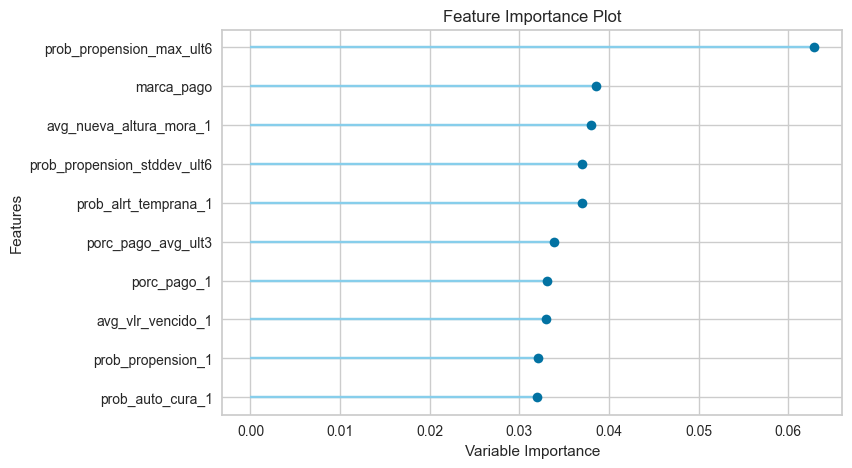

In [32]:
plot_model(best_model_tuned, plot='feature')

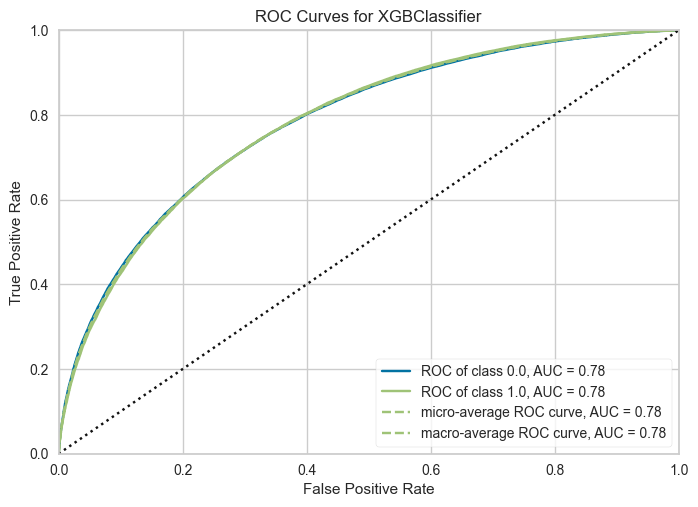

In [33]:
plot_model(best_model_tuned, plot = 'auc')

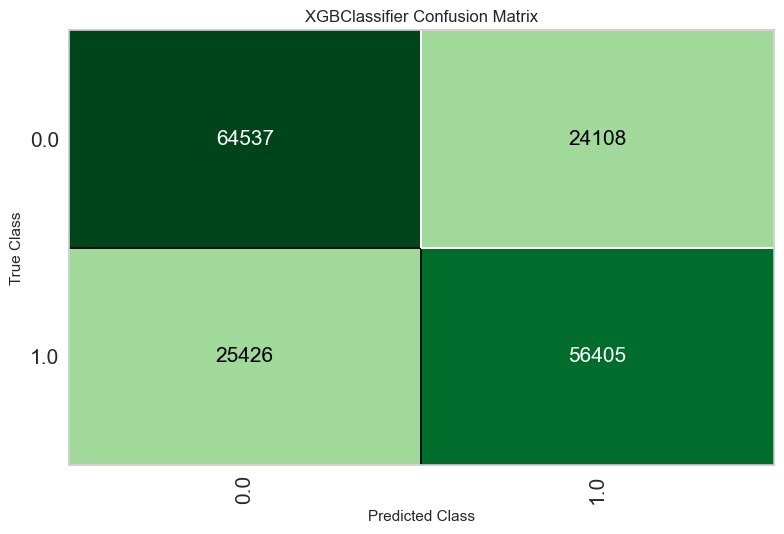

In [34]:
plot_model(best_model_tuned, plot = 'confusion_matrix')

## Calificar

In [37]:
data_calification = data_oot
data_calification["marca_pago"] = data_calification["marca_pago"].map(encoding_dict)
data_calification.head()

,nit_enmascarado,num_oblig_enmascarado,num_oblig_orig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,marca_pago,avg_sld_cap_final_1,avg_sld_cap_final_stddev_ult3,avg_sld_cap_final_stddev_ult6,avg_nueva_altura_mora_1,...,prob_propension_1,prob_propension_stddev_ult3,prob_propension_stddev_ult6,prob_propension_max_ult6,prob_alrt_temprana_1,prob_alrt_temprana_stddev_ult3,prob_alrt_temprana_stddev_ult6,prob_auto_cura_1,prob_auto_cura_stddev_ult3,prob_auto_cura_stddev_ult6
0,188431,915475,172650,202401,NaN,0.381157,1.115650e+06,56538.058644,106435.523222,43.161290,...,0.613275,0.100086,0.084638,0.850847,0.526956,0.178273,0.177695,0.231158,0.251565,0.229240
7,11924,418119,662223,202401,NaN,0.070546,5.257471e+06,92369.722772,191026.429678,1.258065,...,0.926635,0.009008,0.032227,0.928792,0.756745,0.016436,0.016555,0.329941,0.023251,0.103083
22,53587,1072970,5380,202401,NaN,0.381157,4.573333e+06,614118.438724,793011.542182,28.741935,...,0.787768,0.023567,0.019257,0.844610,0.538268,0.030317,0.031753,0.660216,0.023425,0.017381
25,288029,920313,167818,202401,NaN,0.381157,7.316556e+05,35000.676853,28595.554337,28.741935,...,0.767623,0.034803,0.025744,0.845468,0.588393,0.017733,0.069314,0.225435,0.181398,0.217986
36,484667,951087,137018,202401,NaN,0.381157,1.495000e+06,258180.929944,197815.910943,3.322581,...,0.730274,0.007230,0.025558,0.797173,0.455692,0.019965,0.057394,0.348537,0.017139,0.242250


In [63]:
def calification_model(model, data_calification, vars_model, scaler = None):

    data_calification_ = data_calification[vars_model]
    
    if scaler:
        data_calif_norm = data_calification_
        data_calif_norm = scaler.transform(data_calification_.values)
        data_calif_norm = pd.DataFrame(data_calif_norm, columns=vars_model)
    else:
        data_calif_norm = data_calification_
    

    predictios = predict_model(model, data=data_calif_norm, raw_score=True)
    
    data_calification["var_rpta_alt"] = predictios["prediction_label"].values
    data_calification["prediction_score_1"] = predictios["prediction_score_1"].values
    return data_calification

In [64]:
vars_model = data_model_norm.columns
vars_model[:-1]

Index(['marca_pago', 'avg_sld_cap_final_1', 'avg_sld_cap_final_stddev_ult3',
       'avg_sld_cap_final_stddev_ult6', 'avg_nueva_altura_mora_1',
       'avg_nueva_altura_mora_stddev_ult3', 'min_vlr_obligacion_stddev_ult3',
       'avg_vlr_vencido_1', 'valor_cuota_mes_1', 'valor_cuota_mes_stddev_ult3',
       'valor_cuota_mes_stddev_ult6', 'pago_total_1', 'pago_total_avg_ult3',
       'porc_pago_1', 'porc_pago_avg_ult3', 'total_ing_1',
       'total_ing_avg_ult3', 'total_ing_stddev_ult3', 'tot_activos_1',
       'tot_activos_stddev_ult3', 'tot_activos_stddev_ult6', 'egresos_mes_1',
       'egresos_mes_stddev_ult3', 'tot_patrimonio_stddev_ult3',
       'tot_patrimonio_stddev_ult6', 'prob_propension_1',
       'prob_propension_stddev_ult3', 'prob_propension_stddev_ult6',
       'prob_propension_max_ult6', 'prob_alrt_temprana_1',
       'prob_alrt_temprana_stddev_ult3', 'prob_alrt_temprana_stddev_ult6',
       'prob_auto_cura_1', 'prob_auto_cura_stddev_ult3',
       'prob_auto_cura_stddev_u

In [65]:
data_calification = calification_model(best_model_tuned, data_calification, vars_model[:-1], scaler = MM)
data_calification.head()

,nit_enmascarado,num_oblig_enmascarado,num_oblig_orig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,marca_pago,avg_sld_cap_final_1,avg_sld_cap_final_stddev_ult3,avg_sld_cap_final_stddev_ult6,avg_nueva_altura_mora_1,avg_nueva_altura_mora_stddev_ult3,min_vlr_obligacion_stddev_ult3,avg_vlr_vencido_1,valor_cuota_mes_1,valor_cuota_mes_stddev_ult3,valor_cuota_mes_stddev_ult6,pago_total_1,pago_total_avg_ult3,porc_pago_1,porc_pago_avg_ult3,total_ing_1,total_ing_avg_ult3,total_ing_stddev_ult3,tot_activos_1,tot_activos_stddev_ult3,tot_activos_stddev_ult6,egresos_mes_1,egresos_mes_stddev_ult3,tot_patrimonio_stddev_ult3,tot_patrimonio_stddev_ult6,prob_propension_1,prob_propension_stddev_ult3,prob_propension_stddev_ult6,prob_propension_max_ult6,prob_alrt_temprana_1,prob_alrt_temprana_stddev_ult3,prob_alrt_temprana_stddev_ult6,prob_auto_cura_1,prob_auto_cura_stddev_ult3,prob_auto_cura_stddev_ult6,prediction_score_1
0,188431,915475,172650,202401,1,0.381157,1.115650e+06,56538.058644,106435.523222,43.161290,18.053716,115954.798064,5.366218e+05,590444.0,148916.089167,154796.176843,98928.0,581419.666667,17.0,210.333333,1912467.0,1912467.0,0.000000,1039000.0,0.000000e+00,0.000000e+00,4500000.0,1.885618e+06,0.000000e+00,0.000000e+00,0.613275,0.100086,0.084638,0.850847,0.526956,0.178273,0.177695,0.231158,0.251565,0.229240,0.7455
7,11924,418119,662223,202401,0,0.070546,5.257471e+06,92369.722772,191026.429678,1.258065,0.812653,89285.114826,6.086558e+04,236873.0,87.509999,20458.154506,473746.0,473504.000000,200.0,200.000000,1600000.0,1600000.0,0.000000,20443000.0,0.000000e+00,0.000000e+00,400000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.926635,0.009008,0.032227,0.928792,0.756745,0.016436,0.016555,0.329941,0.023251,0.103083,0.2790
22,53587,1072970,5380,202401,1,0.381157,4.573333e+06,614118.438724,793011.542182,28.741935,12.666326,964473.248278,1.116832e+06,1657666.0,573703.842554,498795.134600,389333.0,573933.000000,23.0,174.333333,7355000.0,7355000.0,0.000000,290180000.0,0.000000e+00,0.000000e+00,2340000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.787768,0.023567,0.019257,0.844610,0.538268,0.030317,0.031753,0.660216,0.023425,0.017381,0.8471
25,288029,920313,167818,202401,1,0.381157,7.316556e+05,35000.676853,28595.554337,28.741935,11.086491,77027.273721,1.558860e+05,208501.0,22268.715559,52548.511494,60000.0,283533.333333,29.0,127.666667,5572760.0,5572760.0,0.000000,55451612.0,0.000000e+00,0.000000e+00,1000000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.767623,0.034803,0.025744,0.845468,0.588393,0.017733,0.069314,0.225435,0.181398,0.217986,0.7161
36,484667,951087,137018,202401,1,0.381157,1.495000e+06,258180.929944,197815.910943,3.322581,1.408794,72449.272658,1.067601e+05,155491.0,3430.555932,46632.478935,0.0,293252.666667,0.0,187.000000,1541406.0,1169516.0,262965.940855,6565000.0,2.669564e+06,2.110475e+06,0.0,0.000000e+00,2.669564e+06,2.110475e+06,0.730274,0.007230,0.025558,0.797173,0.455692,0.019965,0.057394,0.348537,0.017139,0.242250,0.7339


In [66]:
data_calification["ID"] = data_calification["nit_enmascarado"].astype(str) + "#" + data_calification["num_oblig_orig_enmascarado"].astype(str) + "#" + data_calification["num_oblig_enmascarado"].astype(str)
new_dataframe = data_calification[["ID", "var_rpta_alt"]]
print(new_dataframe.isna().sum())

ID              0
var_rpta_alt    0
dtype: int64


In [67]:
new_dataframe.to_csv(r"..\data\{}\pmod_base_model_calification.csv".format(experiment_name), index=False)